### 树模型：以GBDT和XGBOOST为代表
循环预测

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from utils import *
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor

random.seed(42)

读取数据

In [2]:
# (term_num, time_steps, feature_num)

gene_arr_path = r'../output/gene_editing/decay_result.array'
transplant_arr_path = r'../output/transplant/decay_result.array'

gene_arr = pickle.load(open(gene_arr_path, mode='rb'))
transplant_arr = pickle.load(open(transplant_arr_path, mode='rb'))

print('Shape of the gene_editing array:',gene_arr.shape)
print('Shape of the transplant array:',transplant_arr.shape)

Shape of the gene_editing array: (2643, 17, 11)
Shape of the transplant array: (5141, 17, 11)


### 截断数据
因2019年两个数据集的EmergingScore大部分都为0，而2018年及之前的情况要好很多，故抛弃2019年数据

In [3]:
gene_arr = gene_arr[:, :-1, :]
transplant_arr = transplant_arr[:, :-1, :]

print('Shape of the gene_editing array:',gene_arr.shape)
print('Shape of the transplant array:',transplant_arr.shape)

Shape of the gene_editing array: (2643, 16, 11)
Shape of the transplant array: (5141, 16, 11)


### 规范数据并获取训练集和测试集
这里的训练集、测试集和序列模型的不同，是滑动窗口

为了保证可比性，使用位置号来标明原来的序列

因为不是序列模型，所以需要展平多变量序列，也可以使用多个神经网络对每一维进行处理

此外，因为是多变量序列，所以模型要预测所有的变量，不然没法循环输入

https://machinelearningmastery.com/how-to-develop-multilayer-perceptron-models-for-time-series-forecasting/

In [4]:
def to_supervised(data, n_inputs, ids_train, ids_test):
    train_data = data[ids_train]
    test_data = data[ids_test]
    
    X_train = list()
    X_test = list()
    y_train = list()
    y_test = list()
    
    for train in train_data:
        for i in range(len(train_data[0]) - n_inputs):
            X_train.append(train[i:i+n_inputs].flatten())
            y_train.append(train[i+n_inputs].flatten())
    
    for test in test_data:
        for i in range(len(test_data[0]) - n_inputs):
            X_test.append(test[i:i+n_inputs].flatten())
            y_test.append(test[i+n_inputs].flatten())
    
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

In [5]:
scaler, data = scale_data(transplant_arr, 'standard')
X_train, X_test, y_train, y_test, ids_train, ids_test = split_data_with_index(data, 11, 0.2)

# 如果不是循环预测则不需要执行下面这一行
X_train, X_test, y_train, y_test = to_supervised(data, 11, ids_train, ids_test)

### 构建模型

In [6]:
def build_parallel_X(data):
    Xs = []
    for i in range(data.shape[2]):
        Xs.append(data[:, :, i])
    return Xs

In [7]:
model =  MultiOutputRegressor(xgb.XGBRegressor(n_estimators=100))

训练

In [8]:
# Xs_train = build_parallel_X(X_train)
# Xs_test = build_parallel_X(X_test)

In [9]:
model.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:382: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='reg:squarederror',
                                           

预测

In [10]:
def recursive_predict(model, X_test, n_inputs, n_features, total_timesteps):
    # 只能用每个里面的第一部分，其他用预测来填充
    gap = total_timesteps - n_inputs
    y_pred = []
    i = 0
    while i < len(X_test):
        history = [num for num in X_test[i]]
        i += gap
        inner_pred = []
        for j in range(total_timesteps - n_inputs):
            X = np.array(history[-n_features * n_inputs:]).reshape(1, n_features * n_inputs)
            pred = list(model.predict(X)[0])
            inner_pred.append(pred[-2])
            history += pred
        y_pred.append(np.array(inner_pred))
    return np.array(y_pred)

In [11]:
y_pred = recursive_predict(model, X_test, 11, 11, 16)
# y_pred = model.predict(X_test).reshape(y_train.shape)

画图

In [12]:
X_train, X_test, y_train, y_test, ids_train, ids_test = split_data_with_index(data, 11, 0.2)

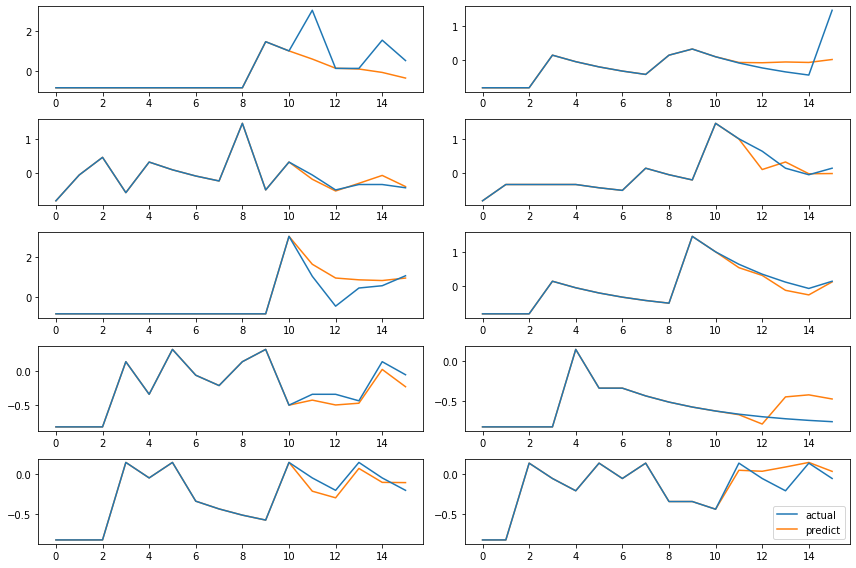

In [56]:
# 训练集
ids = random.sample(range(len(y_test)), 10)

plt.figure(figsize=(12,8))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.plot(np.concatenate((X_train[ids[i], :, -2], y_train[ids[i]].reshape(-1)), axis=None), label='actual', zorder=1)
    plt.plot(np.concatenate((X_train[ids[i], :, -2], y_pred[ids[i]].reshape(-1)), axis=None), label='predict', zorder=0)
plt.legend()
plt.tight_layout()
plt.show()

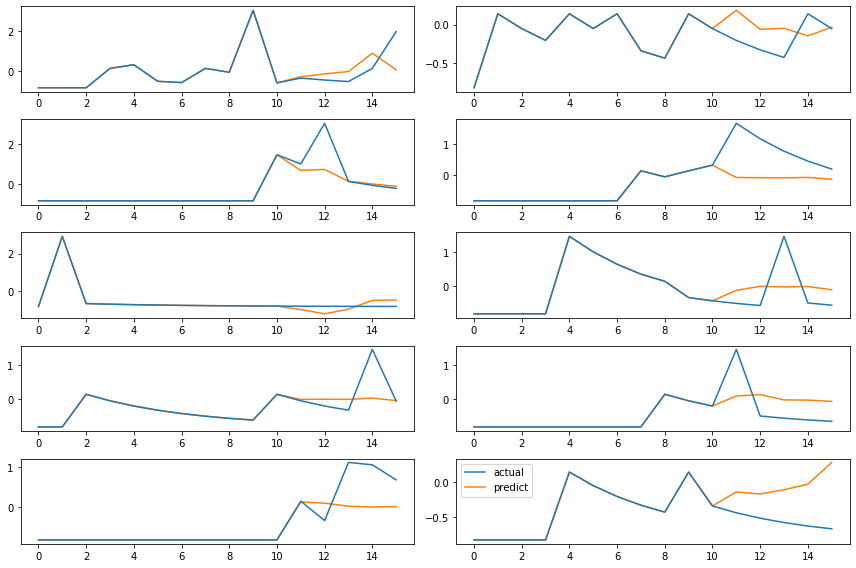

In [24]:
# 测试集
ids = random.sample(range(len(y_test)), 10)

plt.figure(figsize=(12,8))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.plot(np.concatenate((X_test[ids[i], :, -2], y_test[ids[i]].reshape(-1)), axis=None), label='actual', zorder=1)
    plt.plot(np.concatenate((X_test[ids[i], :, -2], y_pred[ids[i]].reshape(-1)), axis=None), label='predict', zorder=0)
plt.legend()
plt.tight_layout()
plt.show()

评估

MAE: 0.7820220097401002
MAEMAE: [0.76270961 0.77310648 0.7879153  0.77974104 0.80663763]


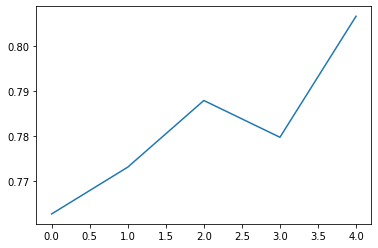

MSE: 1.4950070536722457
MSEMAE: [1.34092929 1.52596112 1.71227778 1.317368   1.57849908]


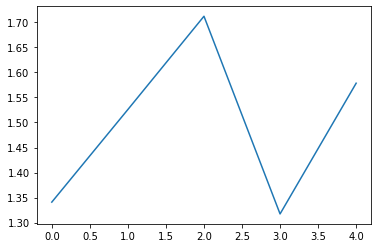

MAPE: 28399909412.371254
MAPEMAE: [8.62697203e+10 4.61023589e+10 4.86776658e+09 4.75970134e+09
 1.43941195e+00]


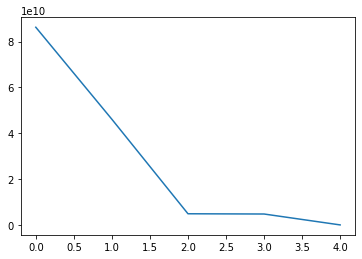

RMSE: 1.22270481052143
RMSEMAE: [1.15798501 1.23529799 1.30854032 1.14776652 1.25638333]


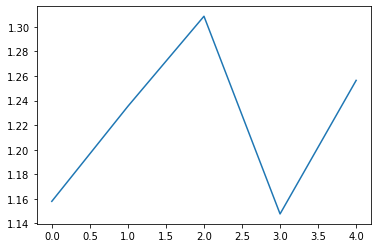

NDCG: 0.8117556291840743
NDCGMAE: [0.5212802220414533, 0.38905951130028893, 0.3381044350767121, 0.44275313471887806, 0.43747111533251537]


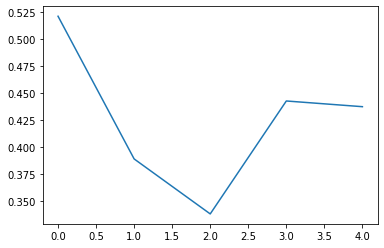

In [17]:
metrics = ['mae', 'mse', 'mape', 'rmse', 'ndcg']

for m in metrics:
    overall, annual = eval_model(m, y_test, y_pred, scaler)
    print('{}:'.format(m.upper()), overall)
    print('{}MAE:'.format(m.upper()),annual)
    plt.plot(annual)
    plt.show()

In [18]:
_y_true, _y_pred = eval_model('classification', y_test, y_pred, scaler)

In [19]:
from sklearn.metrics import classification_report
print(classification_report(_y_true.reshape(-1), _y_pred.reshape(-1)))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        27
         1.0       0.70      0.77      0.73      3248
         2.0       0.28      0.15      0.20      1059
         3.0       0.25      0.06      0.09       548
         4.0       0.13      0.42      0.20       263

    accuracy                           0.55      5145
   macro avg       0.27      0.28      0.25      5145
weighted avg       0.53      0.55      0.52      5145



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
